# Studying Scaling Behaviour of Real Space RG (Bialek Inspired)
In this notebook I will study the scaling behaviour of the real space renormalization group (RG) inspired technique that Bialek et al. 2020 proposed. In the paper they propose a greedy pairwise coarse-graining procedure. They test their algorithm on a dataset containing neuronal data of a mouse. 

Here we consider the same procedure but instead use data sampled from an Ising model and compare it with a Bernoulli (p=0.5) dataset that has 1) no correlation and 2) is maximally correlated.

Furthermore, we compare the pairwise coarse-graining procedure with a random pairwise coarse-graining procedure and study how the scaling is influenced by the change in procedure.

In [1]:
import numpy as np
import matplotlib.pyplot
import PRG.RG_class as rg
import pandas as pd
from PRG.plots_to_analyse_rg_scaling import *
import copy
import time
import warnings
from scipy.stats import binom
warnings.filterwarnings('ignore')

## Loading the datasets
Lets start by loading in the datasets we want to study. We will load in the following 4 datasets

    1. 2d Ising model with L=16x16, T=4, J=1
    
    All below still need to be implemented... The bernoulli ones are probably best sampled from an Ising model
    2. 1d Ising model with L=256, T=4, J=1
    3. Bernoulli (p=0.5) L=256 uncorrelated spins
    4. Bernoulli (p=0.5) L=256 maximally correlated spins

### Filenames

In [2]:
f = "input/mixed_correlation_Nclusters=4_SizeClusters=32.npy"
#f = "input/HG19_k6_datasets/HG19_k6_mu1.00_(20,4,5)_B0.55_N1000_00.dat"
#file_data_gaussian = "input/gaussian_distribution_data.npy"
#f_data_1dising = "

save_plot = True
common_title = "4 clusters of size 32"
output_dir = "figures_mixed_datasets/Nclusters=4_SizeClusters=32/"

### Create a RGObject for each dataset we want to analyse

Dataset contains binary values [0, 1]

- Mean and variance of two random spins:
0.5023193359375 0.24999462068080902
0.5023193359375 0.4999946206518716

- Unique variables in dataset: 132

- Size of dataset = (256, 16384)


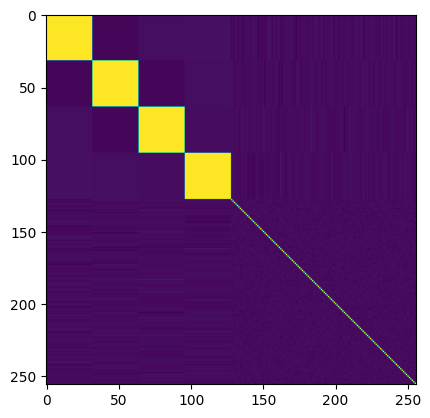

In [3]:
# Initialize a RGObject
RG_random = rg.RGObject()
RG_bialek = rg.RGObject()

# Load dataset
RG_random.load_dataset(f)
RG_bialek.X = copy.deepcopy(RG_random.X)

# Change data to {0, 1} instead of {-1, 1}
RG_bialek.X[RG_bialek.X == -1] = 0
RG_random.X[RG_random.X == -1] = 0
print("Dataset contains binary values [0, 1]")

# Mean value and variance of two spins
print("\n- Mean and variance of two random spins:")
print("==========================================")
print(np.mean(RG_bialek.X[0]), np.var(RG_bialek.X[0]))
print(np.mean(RG_bialek.X[5]), np.std(RG_bialek.X[5]))

# Unique values in the dataset
print(f"\n- Unique variables in dataset: {len(np.unique(RG_random.X, axis=0))}")

# Shape of the dataset
print(f"\n- Size of dataset = {RG_random.X.shape}")


plt.imshow(np.corrcoef(RG_bialek.X))

## To get a feel of the dataset lets have a look at the pairwise correlations

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='correlation coefficient', ylabel='density'>)

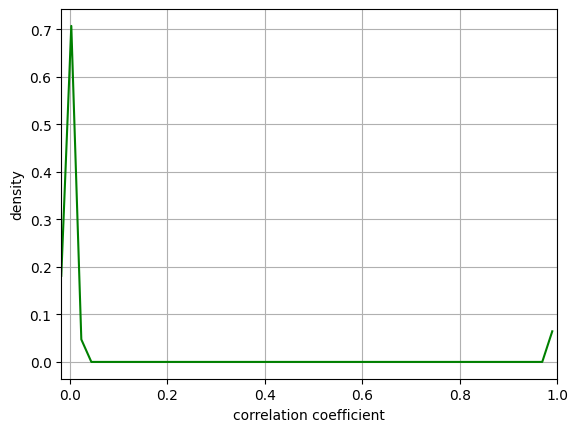

In [4]:
RG_random.plot_correlation_structure_in_dataset()

## Now lets perform two different RG transformations (RGTs) on the dataset
    
1. **method = "random";** perform a random pairwise coarse-graining procedure. At each RG step we reduce the number of spins from N to N/2 by randomly pairing them.

2. **method = "pairwise_clustering_bialek";** perform a pairwise coarse-graining procedure based on the correlation matrix. At each RG step we reduce the number of spins from N to N/2 by 1) finding the highest correlated spins, 2) creating a new spin which contains the normalized summed activity. 3) find next pair and do till every spin is paired.
    

In [5]:
# Lets quickly check the names of the possible RGTs
RG_bialek.list_methods() #NOTE: RBM procedure is not implemented yet

Possible ways to perform the Renormalization group are:
 - 'random': this does a random pairwise clustering at eacht step.
 - 'pairwise_clustering_bialek': this does a pairwise clustering of the highest correlated variables.
 - 'RBM': this trains a set of Restricted Boltzmann Machines at each RG transformation.


In [6]:
# Number of RGTs to perform
largest_cluster_size = 32*16*2
rg_iterations = int(np.log2(largest_cluster_size))
print(rg_iterations)

# Perform random RGTs
t = time.time()
RG_random.perform_real_space_coarse_graining("random", rg_iterations)
print(f"Random RGTs toke {round(time.time() - t, 3)} seconds.")

# Perform Bialek RGTs
t = time.time()
RG_bialek.perform_real_space_coarse_graining("pairwise_clustering_bialek", rg_iterations)
print(f"Bialek RGTs toke {round(time.time() - t, 3)} seconds.")

10
Random RGTs toke 0.048 seconds.
Bialek RGTs toke 0.228 seconds.


## RGTs completed! Extract the data and lets study it.

1. First we compute the **probability distributions of the normalized activity in the clusters**. From this we can find the Free Energy scaling and get an indication about the simplification of the distribution. If the system is moving towards a fixed distribution we can say that we are in a RG fixed point.


2. Furthermore, we can look at the **eigenvalue spectra withing the clusters**. We should expect to see an exponentially decaying spectrum because we know that coarse-graining only makes sense if the high frequency modes (which in a rank/K plot are the right most values) should become less and less relevant for the variance in the clusters. 


3. Something else to look at is the **variance of the eigenspectra**. This should indicate how consistent the coarse-graining procedure is across the different clusters that are formed. High variacne indicates the procedure is not consistently able to average over the same frequency modes. Low variance indicates the opposite.

In [7]:
# Extract data 
Xs_random, clusters_random, _ = RG_random.extract_data()
Xs_bialek, clusters_bialek, _ = RG_bialek.extract_data()

# Compute distributions
p_averages_random, p_stds_random, unique_activity_values_random = RG_random.compute_activity_distributions()
p_averages_bialek, p_stds_bialek, unique_activity_values_bialek = RG_bialek.compute_activity_distributions()

Total running time = 1.008 seconds.
Total running time = 1.009 seconds.


0.4992070198059082


TypeError: cannot unpack non-iterable NoneType object

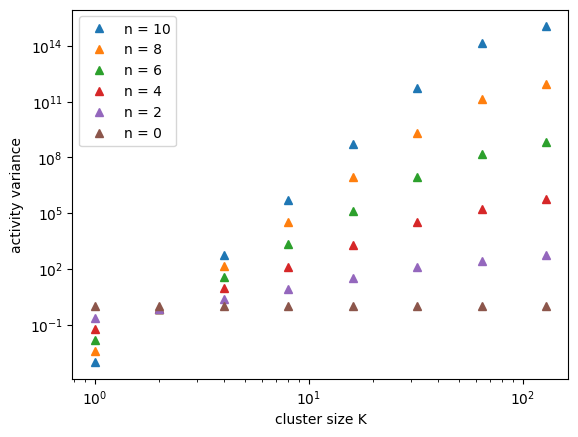

In [8]:
# Plot scaling of variance
moments = np.arange(0, 12, 2)
# moments = [2]
fig, ax = plot_scaling_of_moments(Xs_bialek, clusters_bialek, moments=moments, limits=False)

if save_plot == True:
    fig.savefig()
# moments = [3, 5, 7]
# plot_scaling_of_moments(Xs_bialek, clusters_bialek, title="Bialek", moments=moments)

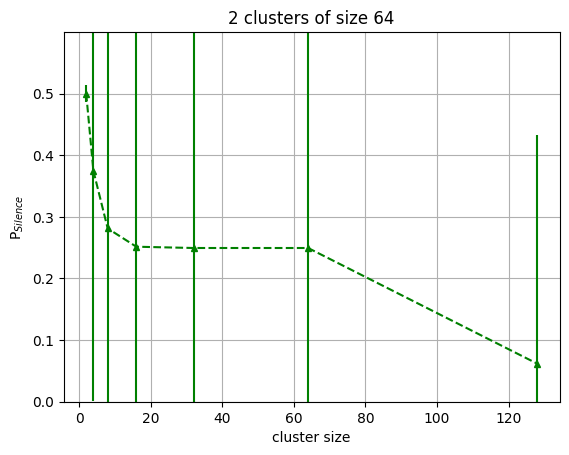

In [ ]:
# Plot free energy 
#plot_free_energy_scaling(p_averages_random, p_stds_random, unique_activity_values_random, clusters_random, title="Random")
plot_free_energy_scaling(p_averages_bialek, p_stds_bialek, unique_activity_values_bialek, clusters_bialek, title="2 clusters of size 64")

FileNotFoundError: [Errno 2] No such file or directory: 'figures_mixed_datasets/Nclusters=4_SizeClusters=32//eigenvalue_spectra_within_clusters.png'

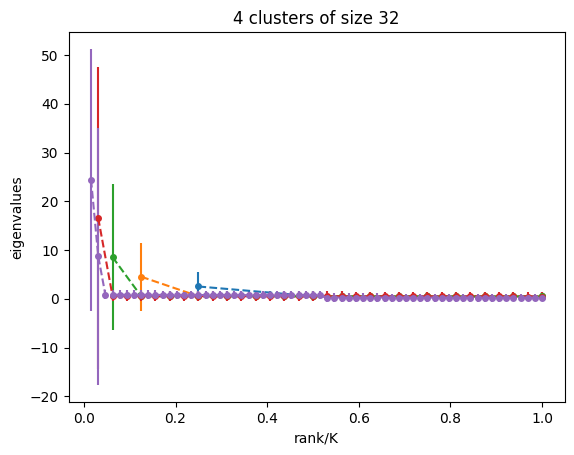

In [ ]:
# Plot eigenvalue spectra
rg_range = (0, len(clusters_bialek)-2)

#plot_eigenvalue_spectra_within_clusters(Xs_random, clusters_random, title="Random")
fig, ax = plot_eigenvalue_spectra_within_clusters(Xs_bialek, clusters_bialek, rg_range)

if common_title == True:
    ax.set_title(common_title)
else:
    title = ""
    ax.set_title(title)

if save_plot == True:
    fig.savefig(f"{output_dir}/eigenvalue_spectra_within_clusters")

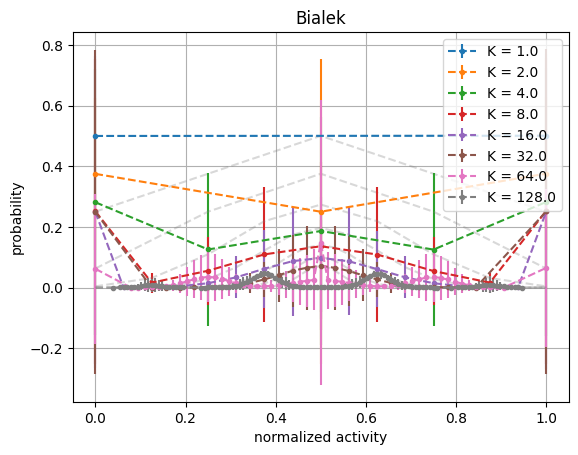

In [ ]:
# Plot distribution of activity
rg_range = (0, len(clusters_bialek))

# Random
# plot_normalized_activity(p_averages_random,
#                          p_stds_random,
#                          unique_activity_values_random,
#                          clusters_random,
#                          rg_range,
#                          title="Random")

# Bialek
plot_normalized_activity(p_averages_bialek,
                         p_stds_bialek,
                         unique_activity_values_bialek,
                         clusters_bialek,
                         rg_range,
                         title="Bialek")

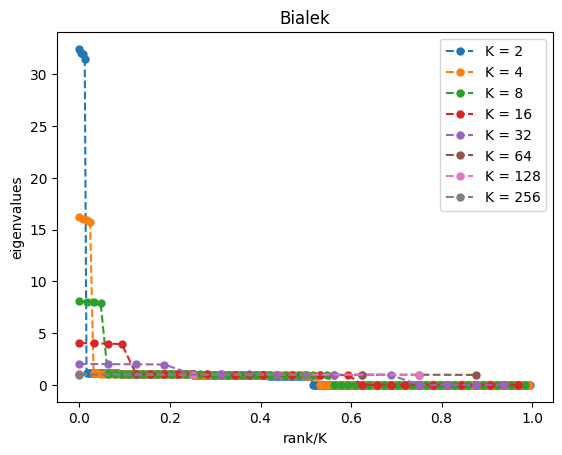

In [ ]:
# Plot the eigenvalue spectrum of the coarse-grained variables at different points in the RGTs
# plot_eigenvalue_scaling(Xs_random, clusters_bialek, title="Random")
plot_eigenvalue_scaling(Xs_bialek, clusters_random, title="Bialek")

Bialek
###############################


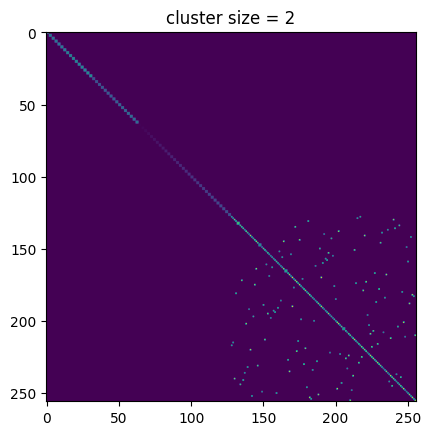

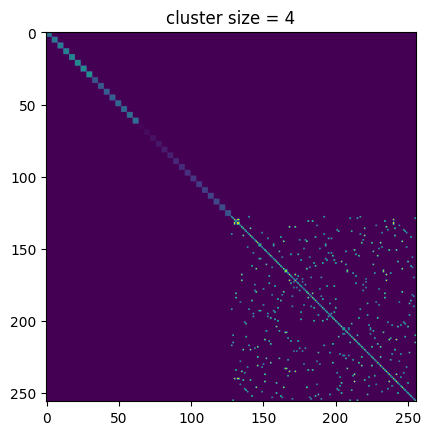

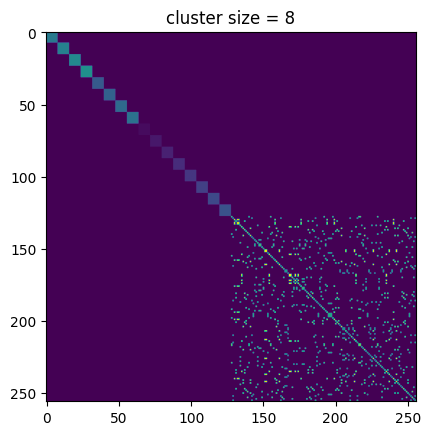

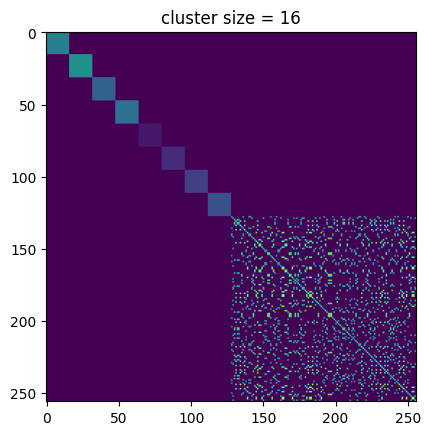

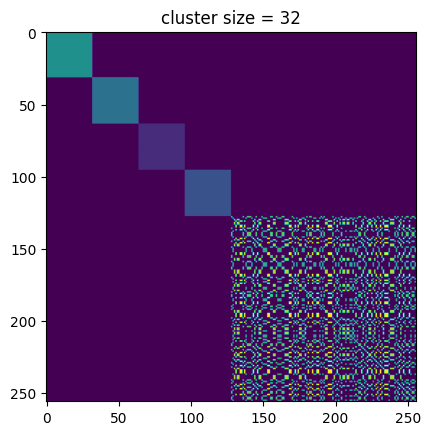

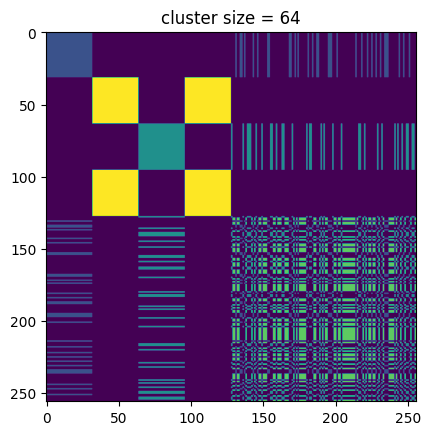

In [11]:

def show_clusters_by_imshow(clusters, rg_range, OUTPUT_DIR):
    """
    Show the clusters that are formed during the RG procedure.

    Parameters:
        cluster - ndarray containing the clusters at the different iterations of the RG transformation
        verbose (optional) - if True it prints the cluster list after showing the image 
    """

    original_size = len(clusters[0][0]) * len(clusters[0][:, 0])
    grid = np.zeros((original_size, original_size))
    for c in clusters[rg_range[0]:rg_range[1]]:

        # Create fig, ax
        fig, ax = plt.subplots(1)

        colors = np.arange(1, 1 + len(c[:,0])) / len(c[:,0]) * 10
        for i, color in enumerate(colors):
            for j in c[i]:
                grid[j, c[i]] = color
        
        ax.imshow(grid)
        ax.set_title(f"cluster size = {len(c.T)}")
        fig.savefig(f"{OUTPUT_DIR}/clusterSize={len(c.T)}")

# print("Random\n###############################")
# show_clusters_by_imshow(clusters_random)
print("Bialek\n###############################")
rg_range = (0, len(clusters_bialek)- 2)
show_clusters_by_imshow(clusters_bialek, rg_range, "")

In [ ]:
n = 100
l, p = 0.2506103515625, 1.52587890625e-05
x = np.random.rand(1, 2, n) * l
y = np.random.rand(1, 2, n) * p
X = np.array([x, y]).reshape(-1)
np.mean(X), np.std(X)*2

(0.059445121523959504, 0.15365450838913675)

In [ ]:
import scipy.stats as st

X = st.bernoulli.rvs(0.5, size=2**14)

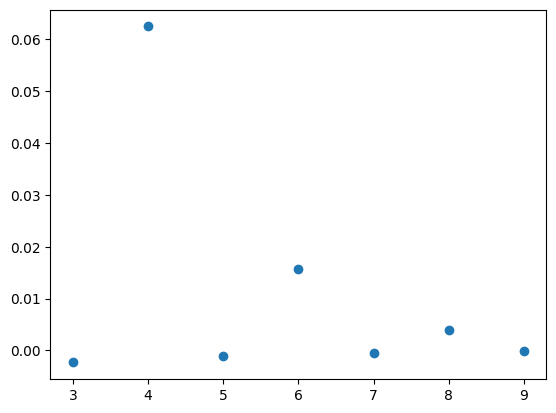

In [ ]:
moments = []
for i in range(3, 10):
    m = st.moment(X, i)
    moments.append(m)

plt.scatter(range(3, 10), moments)
plt.show()

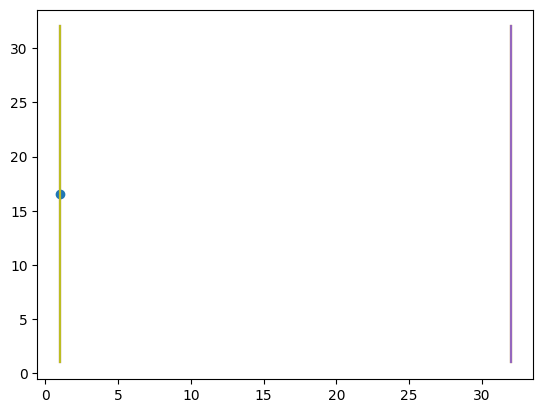

In [15]:
X = [32, 32, 32, 32, 1, 1, 1, 1]
x16 = np.percentile(X, 16)
x84 = np.percentile(X, 84)
plt.plot(1, np.median(X), 'o')
plt.plot([X,X], [x16,x84], '-')